## autocomplete service to return a list of top-10 documents based on their titles.

In [1]:
import tkinter as tk
from tkinter import font
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import time
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}], http_auth=('farah', 'farah123'))
index = 'reuters_index_irproj'

C:\Users\Rahhal AbuZahra\AppData\Local\Temp\ipykernel_15600\568568322.py:1: DeprecationWarning: The 'http_auth' parameter is deprecated. Use 'basic_auth' or 'bearer_auth' parameters instead
  es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}], http_auth=('farah', 'farah123'))


In [3]:
def search_es(title):
    try:
        
        query = {
            "query": {
                "match": {
                    "title": title
                }
            },
            "size": 10  # top 10 
        }
        result = es.search(index=index, body=query)

        # Extract and return relevant information from the result
        hits = result['hits']['hits']
        return [hit['_source'] for hit in hits]

    except ConnectionError:
        return None

In [4]:
def autocomplete(event):
    query = entry.get()

    if len(query) < 3:
        suggestion_listbox.delete(0, tk.END)
        return  # Don't suggest until at least 3 characters are typed

    try:
        es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}], http_auth=('farah', 'farah123'))
        index = 'reuters_index_irproj'
        
        query_body = {
            "query": {
                "match": {
                    "title.autocomplete": {
                        "query": query,
                        "fuzziness": "AUTO",
                        "prefix_length": 2,
                    }
                }
            },
            "size": 10
        }

        suggestions = es.search(index=index, body=query_body)['hits']['hits']

        # Extract and display autocomplete suggestions
        suggestion_listbox.delete(0, tk.END)
        for suggestion in suggestions:
            title = suggestion['_source']['title']
            suggestion_listbox.insert(tk.END, title)

    except Exception as e:
        print(f"Error: {e}")

In [5]:
#when a suggestion is selected from the listbox
def on_suggestion_select(event):
    selected_index = suggestion_listbox.curselection()
    if selected_index:
        selected_suggestion = suggestion_listbox.get(selected_index)
        entry.delete(0, tk.END)
        entry.insert(tk.END, selected_suggestion)
        # Clear the suggestions after choosing one
        suggestion_listbox.delete(0, tk.END)

In [6]:
#when the search button is clicked
def on_search_click():
    title = entry.get()
    # Record the start time
    start_time = time.time()
    results = search_es(title)
    # Record the end time
    end_time = time.time()

    if results is not None:
        result_text.config(state=tk.NORMAL)
        result_text.delete(1.0, tk.END)  # Clear previous results

        num_results = len(results)
        result_text.insert(tk.END, f"About {num_results} results in {end_time - start_time:.4f} seconds \n\n")

        for result in results:
            formatted_result = f"Title: {result.get('title', 'N/A')}\n" \
                               f"Date: {result.get('date', 'N/A')}\n" \
                               f"Topic: {result.get('topic', 'N/A')}\n\n" \
                               f"  {result.get('body', 'N/A')}\n\n{'='*50}\n"
            result_text.insert(tk.END, formatted_result)

        result_text.config(state=tk.DISABLED)
        # Clear the input after displaying results
        entry.delete(0, tk.END)
    else:
        result_text.config(state=tk.NORMAL)
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, "Error connecting to Elasticsearch.")
        result_text.config(state=tk.DISABLED)

In [12]:
# Create the main window
root = tk.Tk()
root.title("Autocomplete Search")

# Customize the style
input_width = 40
font_style = font.Font(family="Times New Roman", size=12, slant="roman")

label = tk.Label(root, text="Enter title:", font=font_style)
label.pack()

entry_frame = tk.Frame(root)
entry_frame.pack()

entry = tk.Entry(entry_frame, width=input_width, font=font_style)
entry.pack(side=tk.LEFT, padx=5)  

search_button = tk.Button(entry_frame, text="Search", command=on_search_click, font=font_style)
search_button.pack(side=tk.LEFT, padx=5, pady=5)  

result_text = tk.Text(root, height=10, width=80, state=tk.DISABLED, font=font_style)
result_text.pack()

# Autocomplete suggestion listbox
suggestion_listbox = tk.Listbox(root, height=5, selectmode=tk.SINGLE, font=font_style, width=60)
suggestion_listbox.pack()

# Bind events
entry.bind("<KeyRelease>", autocomplete)
suggestion_listbox.bind("<ButtonRelease-1>", on_suggestion_select)

# Start the GUI event loop
root.mainloop()


C:\Users\Rahhal AbuZahra\AppData\Local\Temp\ipykernel_15600\3783121619.py:9: DeprecationWarning: The 'http_auth' parameter is deprecated. Use 'basic_auth' or 'bearer_auth' parameters instead
  es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}], http_auth=('farah', 'farah123'))


## considering both title and content

##### Retrieving relevant documents by considering both title and content, with greater emphasis placed on the title. Also, take into consideration the recency and localization factors while ranking the results. Note that the query from the user is represented as a tuple (query, temporal expression, georeference)


In [8]:
def get_geopoints_and_georeferences_for_document(document_id):
    # Fetch the specified document by ID
    document_query = {"query": {"ids": {"values": [document_id]}}}
    document_result = es.search(index=index, body=document_query)

    # Extract geopoints.loc and georeferences.loc values
    geopoints = document_result['hits']['hits'][0]['_source'].get('geopoints', [])
    georeferences = document_result['hits']['hits'][0]['_source'].get('georeferences', [])

    loc_values_geopoints = [geopoint.get('loc', 'N/A') for geopoint in geopoints]
    loc_values_georeferences = [georeference.get('loc', 'N/A') for georeference in georeferences]

    return loc_values_geopoints, loc_values_georeferences

In [9]:
def search_documents():
    user_query = query_entry.get()
    user_temporal_expression = temporal_expression_entry.get()
    location = georeference_entry.get() 

    query = {
    "query": {
        "bool": {
            "should": [
                {
                    "function_score": {
                        "query": {
                            "match": {
                                "title.autocomplete": {
                                    "query": user_query,
                                    "operator": "and"
                                }
                            }
                        },
                        "boost": 2  # Boost the title's relevance
                    }
                },
                {
                    "match": {
                        "body": {
                            "query": user_query,
                            "operator": "and"
                        }
                    }
                }
            ]
        }
    },
    "sort": [
        {
            "date.keyword": {
                "order": "desc"
            }
        }
    ]
}

    results = es.search(index=index, body=query)['hits']['hits']
    # print(results)

    # Filter results based on geolocation
    filtered_results = []
    for result in results:
        doc_id = result['_id']
        geopoints, georeferences = get_geopoints_and_georeferences_for_document(doc_id)
         # print(geopoints)
        if location in georeferences or location in geopoints:
               # print(location)
               document_temporal_expressions = result['_source'].get('temporal_expressions', [])
             # print(document_temporal_expressions)
               if any(expression.get('expression') == user_temporal_expression for expression in document_temporal_expressions):
                    filtered_results.append(result)
    

    display_results(filtered_results)




In [10]:
# Function to display results in the GUI
def display_results(results):
    results_text.config(state=tk.NORMAL)

    for result in results:
        title = result['_source'].get('title', 'N/A')
        date = result['_source'].get('date', 'N/A')
        topic = result['_source'].get('topic', 'N/A')
        
        # Extract and print "loc" values from "geopoints"
        geopoints = result['_source'].get('geopoints', [])
        loc_values_geopoints = [geopoint.get('loc', 'N/A') for geopoint in geopoints]
        loc_values_geopoints_str = ', '.join(loc_values_geopoints)

        # Extract and print "loc" values from "georeferences"
        georeferences = result['_source'].get('georeferences', [])
        loc_values_georeferences = [georeference.get('loc', 'N/A') for georeference in georeferences]
        loc_values_georeferences_str = ', '.join(loc_values_georeferences)
        
        body = result['_source'].get('body', 'N/A')

        # Print results in the GUI
        result_str = f"Title: {title}\nDate: {date}\nTopic: {topic}\nplaces: {loc_values_geopoints_str} {loc_values_georeferences_str}\n\n{body}\n\n"
        results_text.insert(tk.END, result_str)

    results_text.config(state=tk.DISABLED)


In [11]:
root = tk.Tk()
root.title("Elasticsearch Query Interface")

input_width = 40
font_style = font.Font(family="Times New Roman", size=12, slant="roman")

# Input widgets
tk.Label(root, text="Query:", font=font_style).pack()
query_entry = tk.Entry(root, width=input_width, font=font_style)
query_entry.pack()

tk.Label(root, text="Temporal Expression:", font=font_style).pack()
temporal_expression_entry = tk.Entry(root, font=font_style,width=input_width)
temporal_expression_entry.pack()

tk.Label(root, text="Georeference:", font=font_style).pack()
georeference_entry = tk.Entry(root, width=input_width, font=font_style)
georeference_entry.pack()

search_button = tk.Button(root, text="Search", command=search_documents)
search_button.pack()

results_frame = tk.Frame(root)
results_frame.pack()
results_text = tk.Text(results_frame, height=10)
results_text.pack()
root.mainloop()

## Return the top-10 mentioned georeferences across the entire index.


In [56]:
#bucket aggregation
top_georeferences_query = {
    "size": 0,
    "aggs": {
        "top_georeferences": {
            "nested": {
                "path": "georeferences"
            },
            "aggs": {
                "locations": {
                    "terms": {
                        "field": "georeferences.loc",
                        "size": 10
                    }
                }
            }
        }
    }
}


response = es.search(index=index, body=top_georeferences_query)
# print(response)

top_georeferences_buckets = response["aggregations"]["top_georeferences"]["locations"]["buckets"]
for bucket in top_georeferences_buckets:
    georeference = bucket["key"]
    count = bucket["doc_count"]
    print(f"Georeference: {georeference}, Count: {count}")
    

Georeference: U.S., Count: 277
Georeference: Japan, Count: 78
Georeference: Brazil, Count: 51
Georeference: Mexico, Count: 51
Georeference: Taiwan, Count: 24
Georeference: the United States, Count: 24
Georeference: Philippines, Count: 23
Georeference: London, Count: 22
Georeference: New York, Count: 22
Georeference: U.K., Count: 22


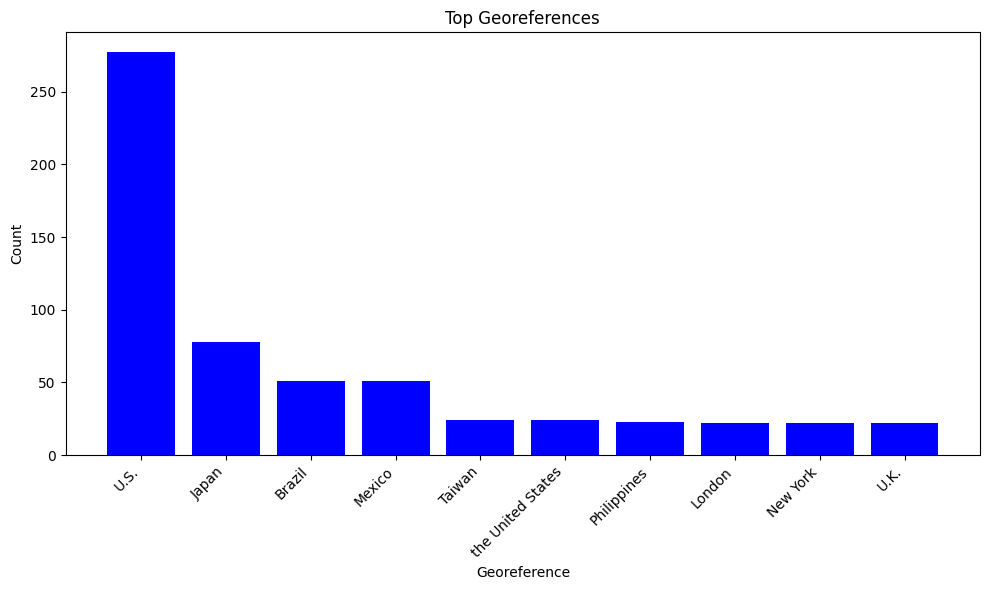

In [57]:
geo_x=[]
count_y=[]
for bucket in top_georeferences_buckets:
    georeference = bucket["key"]
    count = bucket["doc_count"]
    geo_x.append(georeference)
    count_y.append(count)
    
plt.figure(figsize=(10, 6))
plt.bar(geo_x, count_y, color='blue')
plt.xlabel('Georeference')
plt.ylabel('Count')
plt.title('Top Georeferences')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

## Return the distribution of documents over time, with a time aggregation of 1 day

In [13]:
#date histogram aggregation
query = {
    "size": 0,
    "aggs": {
        "documents_over_time": {
            "date_histogram": {
                "script": {
                    "source": """
                        def date_str = doc['date.keyword'].value;
                        def formatter = DateTimeFormatter.ofPattern("yyyy-MM-dd HH:mm:ss");
                        def date = LocalDateTime.parse(date_str, formatter);
                        return date.toInstant(ZoneOffset.UTC).toEpochMilli();
                    """,
                    "lang": "painless"
                },
                "fixed_interval": "1d",
                "min_doc_count": 0,
            }
        }
    }
}
# Execute the query
result = es.search(index=index, body=query)

# Extract and print the aggregation results
histogram_data = result['aggregations']['documents_over_time']['buckets']
for bucket in histogram_data:
    date = bucket['key_as_string']
    doc_count = bucket['doc_count']
    print(f"Date: {date}, Document Count: {doc_count}")

Date: 1987-03-19T00:00:00.000Z, Document Count: 538
Date: 1987-03-20T00:00:00.000Z, Document Count: 462


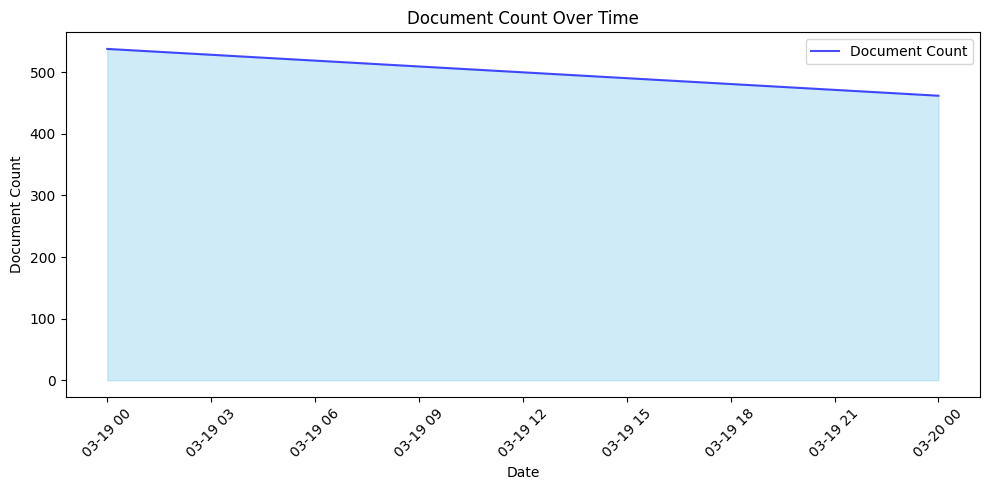

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(histogram_data)
df['date'] = pd.to_datetime(df['key_as_string'])
df.set_index('date', inplace=True)

# Plot an area plot
plt.figure(figsize=(10, 5))
plt.fill_between(df.index, df['doc_count'], color='skyblue', alpha=0.4)
plt.plot(df.index, df['doc_count'], color='blue', alpha=0.7, label='Document Count')
plt.title('Document Count Over Time')
plt.xlabel('Date')
plt.ylabel('Document Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()